In [1]:
import os
import ee
import datetime
import time
import sklearn
import importlib

import geopandas as gp
import pandas as pd
import numpy as np
import rsfuncs as rs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

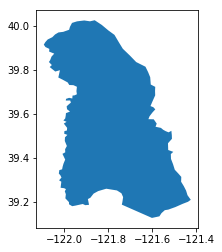

In [3]:
gdf = gp.read_file("../shape/butte_gw_model.shp")
gdf.plot()

In [4]:
area = rs.gdf_to_ee_poly(gdf)

In [11]:
# Time params 
years = range(2001, 2018)
months = range(1,13)
startdate = datetime.datetime(years[0], 1, 1)
enddate = datetime.datetime(years[-1]+1, 2, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [34]:
def get_landsat(year):

    '''
    select the appropriate landsat based on operation years 
    '''

    landsats = {"L4":ee.ImageCollection('LANDSAT/LT04/C01/T1_SR'), 
            "L5": ee.ImageCollection('LANDSAT/LT05/C01/T1_SR'),
            "L7":ee.ImageCollection('LANDSAT/LE07/C01/T1_SR'),
            "L8":ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")}

    if year < 1982 : 
        print("No landsat available")
    if year < 1993 and year > 1982:
        landsat = landsats['L4']
    if year < 2012 and year >1993:
        landsat = landsats['L5']
    if year < 2013 and year >=2012:
        landsat = landsats['L7']
    elif year >=2013: 
        landsat = landsats['L8']

    return landsat

def get_QA_bits(image, start, end, field_name):

    '''
    retrieve quality bits from landsat
    '''

    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
    return image.select([0], [field_name]).bitwiseAnd(pattern).rightShift(start)

def mask_quality(image):

    '''
    mask clouds and shoaws from landsat
    '''

    QA = image.select('pixel_qa')
    # Get the internal_cloud_algorithm_flag bit.
    shad = get_QA_bits(QA,3,3,'cloud_shadow')
    cloud = get_QA_bits(QA,5,5,'cloud')
    cirrus_detected = get_QA_bits(QA,9,9,'cirrus_detected')
    #Return an image masking out cloudy areas.
    return image.updateMask(shad.eq(0)).updateMask(cloud.eq(0).updateMask(cirrus_detected.eq(0))).unmask()

def get_data(year, start_doy, bounds):

    col1 = get_landsat(year).filter(ee.Filter.calendarRange(start_doy-8,start_doy+8, 'day_of_year')).filter(ee.Filter.calendarRange(year,year,'year'))
    col2 = col1.filterBounds(bounds).map(mask_quality)

    # landsat sr bandnames 
    bandnames = ["B1","B2", "B3", "B4", "B5", "B6", "B7"]

    ims = []
    for band in bandnames:
        ims.append(array_from_col(col2, band, 500, bounds))

    out = [np.nan_to_num(x) for x in ims]

    return out 


def array_from_col(col,band,res,bounds):
    
    '''
    Transform an ee.ImageCollection class to a numpy array
    
    Args: 
    
    col: ee.ImageColletion ex 'LANDSAT/LT04/C01/T1_SR'
    band: string, ex "B1" '
    res: int, ex: 30
    
    #     start = ee.Date.fromYMD(year,month,day)
    #     end = start.advance(1,'month')
    #     col = get_landsat(year).filterBounds(area).filterDate(start, end).map(mask_quality)
        
    '''

    # get the lat lon and add the band and scale by the appropriate factor (0.0001 for landsat)
    band_name = col.select(band).median()
    latlon = ee.Image.pixelLonLat().addBands(band_name).multiply(0.0001)

    # apply reducer to list
    latlon = latlon.reduceRegion(
      reducer=ee.Reducer.toList(),
      geometry=bounds,
      maxPixels=1e13,
      scale=res)
    
    data = np.array((ee.Array(latlon.get(band)).getInfo()))
    lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
    lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
    
    arr = array_from_coords(data,lats,lons)
    
    return (arr)

def array_from_coords(data,lats,lons):
    
    '''
    Return a numpy array (ie cartesian product) from lats, lons, and data values
    '''
    
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] 
                
    return arr



In [35]:
data = []

for i in dt_idx:
    lcol = get_landsat(i.year)
    doy = i.timetuple().tm_yday
    data.append(get_data(i.year, doy, area))

IndexError: index 2615 is out of bounds for axis 0 with size 2615

In [26]:
start_doy

31